# Introduction

In this project, we plan to build a model from loan data **that will determine whether a person is eligible for a loan by examining the individual's information.** In this project, three algorithms, `Logistic Regression`, `KNN`, and `ANN`, are used separately, and the results of each will be examined separately, and a final conclusion will be made as to which algorithm performed better for this problem according to the metrics.

In [337]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score

In [338]:
def tune_threshold(y_true, y_proba, thresholds):
    results = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        results.append({
            'threshold': t,
            'precision': precision,
            'recall': recall,
            'FP': fp,
            'FN': fn
        })

    return results


# Data Understanding and Preprocessing

In this section, we first read the data and store it in a dataframe, and after a brief look at the data, we handle null values.

In [339]:
df_loan = pd.read_csv("../data/raw/loan.csv")
display(df_loan.head())
df_loan.isna().sum()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [340]:

# Handling missing values
for col in df_loan.columns:
    if df_loan[col].dtype == 'object':
        df_loan.fillna({col: df_loan[col].mode()[0]}, inplace=True)
    else:
        df_loan.fillna({col: df_loan[col].median()}, inplace=True)
display(df_loan.isna().sum())
df_loan.head()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


We used the mode strategy here for the string value columns because it can be the most appropriate way to fill the string data, given the data distribution.
And for the numeric data, the median was used because using the mean could be quite problematic due to the presence of outlier data, especially in the columns related to income data.

In [341]:
# Encoding categorical variables
df_loan = pd.get_dummies(df_loan, drop_first=True)
df_loan.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,5849,0.0,128.0,360.0,1.0,True,False,False,False,False,False,False,False,True,True
1,4583,1508.0,128.0,360.0,1.0,True,True,True,False,False,False,False,False,False,False
2,3000,0.0,66.0,360.0,1.0,True,True,False,False,False,False,True,False,True,True
3,2583,2358.0,120.0,360.0,1.0,True,True,False,False,False,True,False,False,True,True
4,6000,0.0,141.0,360.0,1.0,True,False,False,False,False,False,False,False,True,True


Well, of course, since the machine learning models we are discussing have no understanding of non-numeric data, we use this short and simple but very useful command to convert our categorical string values ​​into `one-hot encoding` and make the data understandable to the model.

# Train, Validation and Test Split

In this section, considering the **supervised nature of the algorithm** and the **labeled data**, we separate the `X` and `y` data and then split the data related to **train**, **validation**, and **test**.

In [342]:
X = df_loan.drop('Loan_Status_Y', axis=1)
y = df_loan['Loan_Status_Y']

X_temp , X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1875, random_state=42, stratify=y_temp)

In the current state, 65% of our data is divided for model training, 15% for model validation, and 20% for model testing.

# Model Training with Pipeline and Scaling

In this section, we create a `pipeline` for each algorithm that takes care of data scaling and model building, and then we use `grid search` to find the best model parameters.

LogisticRegression Validation Precision Score: 0.8153846153846154
Accuracy: 0.7526881720430108


Text(50.722222222222214, 0.5, 'Actual')

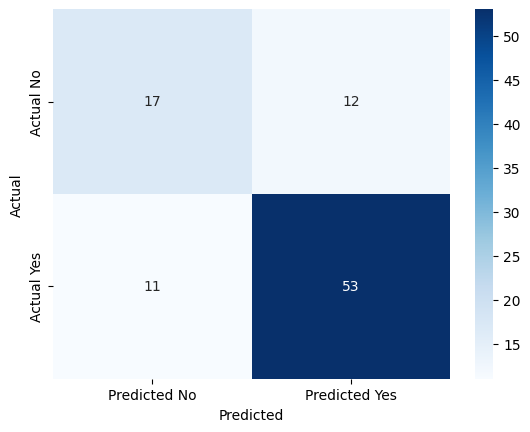

In [362]:
# Logistic Regression with scaler
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 3, 1: 1}))
])

param_grid_lr = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'lbfgs'],
    'model__class_weight': [{0: 1, 1: 1}, {0: 2, 1: 1}, {0: 3, 1: 1}]
}

grid_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    cv=5,
    scoring='precision',
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

best_model_lr = grid_lr.best_estimator_

calibrated_lr = CalibratedClassifierCV(best_model_lr, method='isotonic', cv=5)
calibrated_lr.fit(X_train, y_train)

y_val_pred_lr = best_model_lr.predict(X_val)
y_proba_lr = calibrated_lr.predict_proba(X_val)[:, 1]
y_val_pred_lr = (y_proba_lr >= 0.74).astype(int) # best treshold using treshold tuning

print("LogisticRegression Validation Precision Score:", precision_score(y_val, y_val_pred_lr))
print("Accuracy:", accuracy_score(y_val, y_val_pred_lr))

mat = confusion_matrix(y_val, y_val_pred_lr)
sns.heatmap(
    mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted No', 'Predicted Yes'],
    yticklabels=['Actual No', 'Actual Yes']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')

LogisticRegression Validation Precision Score: 0.8153846153846154
Accuracy: 0.7526881720430108


Text(50.722222222222214, 0.5, 'Actual')

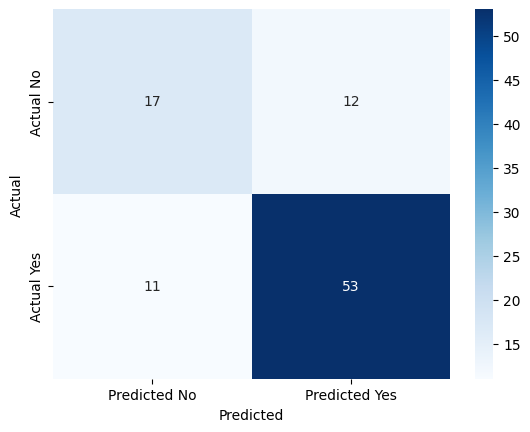

In [363]:
# Logistic Regression without scaler
pipe_lr_no_scaling = Pipeline([
    ('model', LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 3, 1: 1}))
])

param_grid_lr_no_scaling = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'lbfgs'],
    'model__class_weight': [{0: 1, 1: 1}, {0: 2, 1: 1}, {0: 3, 1: 1}]
}

grid_lr_no_scaling = GridSearchCV(
    pipe_lr_no_scaling,
    param_grid_lr_no_scaling,
    cv=5,
    scoring='precision',
    n_jobs=-1
)

grid_lr_no_scaling.fit(X_train, y_train)

best_model_lr_no_scaling = grid_lr_no_scaling.best_estimator_

calibrated_lr_ns = CalibratedClassifierCV(best_model_lr, method='isotonic', cv=5)
calibrated_lr_ns.fit(X_train, y_train)

y_val_pred_lr_no_scaling = best_model_lr_no_scaling.predict(X_val)
y_proba_lr_ns = calibrated_lr_ns.predict_proba(X_val)[:, 1]
y_val_pred_lr_no_scaling = (y_proba_lr_ns >= 0.74).astype(int) # best treshold using treshold tuning

print("LogisticRegression Validation Precision Score:", precision_score(y_val, y_val_pred_lr_no_scaling))
print("Accuracy:", accuracy_score(y_val, y_val_pred_lr_no_scaling))

mat = confusion_matrix(y_val, y_val_pred_lr_no_scaling)
sns.heatmap(
    mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted No', 'Predicted Yes'],
    yticklabels=['Actual No', 'Actual Yes']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')

LogisticRegression Validation Precision Score: 0.8088235294117647
Accuracy: 0.7634408602150538


Text(50.722222222222214, 0.5, 'Actual')

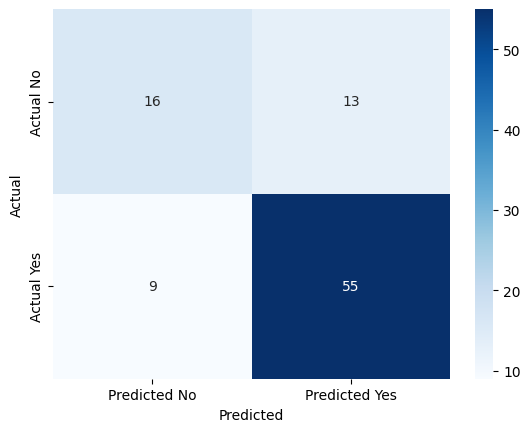

In [344]:
# KNN with scaler
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
])

param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9],
    'model__weights': ['uniform', 'distance'],
}

grid_knn = GridSearchCV(
    pipe_knn,
    param_grid_knn,
    cv=5,
    scoring='precision_macro',
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)

best_model_knn = grid_knn.best_estimator_

calibrated_knn = CalibratedClassifierCV(best_model_knn, method='isotonic', cv=5)
calibrated_knn.fit(X_train, y_train)

y_val_pred_knn = grid_knn.predict(X_val)
y_proba_knn = calibrated_knn.predict_proba(X_val)[:, 1]

y_val_pred_knn = (y_proba_knn >= 0.68).astype(int) # best treshold using treshold tuning

print("LogisticRegression Validation Precision Score:", precision_score(y_val, y_val_pred_knn))
print("Accuracy:", accuracy_score(y_val, y_val_pred_knn))

mat = confusion_matrix(y_val, y_val_pred_knn)
sns.heatmap(
    mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted No', 'Predicted Yes'],
    yticklabels=['Actual No', 'Actual Yes']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')

LogisticRegression Validation Precision Score: 0.6461538461538462
Accuracy: 0.5161290322580645


Text(50.722222222222214, 0.5, 'Actual')

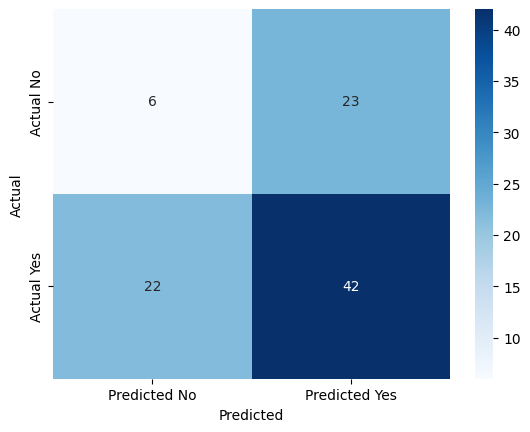

In [366]:
# KNN without scaler
pipe_knn_ns = Pipeline([
    ('model', KNeighborsClassifier())
])

param_grid_knn_no_scaling = {
    'model__n_neighbors': [3, 5, 7, 9],
    'model__weights': ['uniform', 'distance'],
}

grid_knn_ns = GridSearchCV(
    pipe_knn_ns,
    param_grid_knn_no_scaling,
    cv=5,
    scoring='precision_macro',
    n_jobs=-1
)

grid_knn_ns.fit(X_train, y_train)

best_model_knn_ns = grid_knn_ns.best_estimator_

calibrated_knn_ns = CalibratedClassifierCV(best_model_knn_ns, method='isotonic', cv=5)
calibrated_knn_ns.fit(X_train, y_train)

y_val_pred_knn_ns = grid_knn_ns.predict(X_val)
y_proba_knn = calibrated_knn_ns.predict_proba(X_val)[:, 1]
y_val_pred_knn_ns = (y_proba_knn >= 0.68).astype(int) # best treshold using treshold tuning

print("LogisticRegression Validation Precision Score:", precision_score(y_val, y_val_pred_knn_ns))
print("Accuracy:", accuracy_score(y_val, y_val_pred_knn_ns))

mat = confusion_matrix(y_val, y_val_pred_knn_ns)
sns.heatmap(
    mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted No', 'Predicted Yes'],
    yticklabels=['Actual No', 'Actual Yes']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')

LogisticRegression Validation Precision Score: 0.8064516129032258
Accuracy: 0.7204301075268817


Text(50.722222222222214, 0.5, 'Actual')

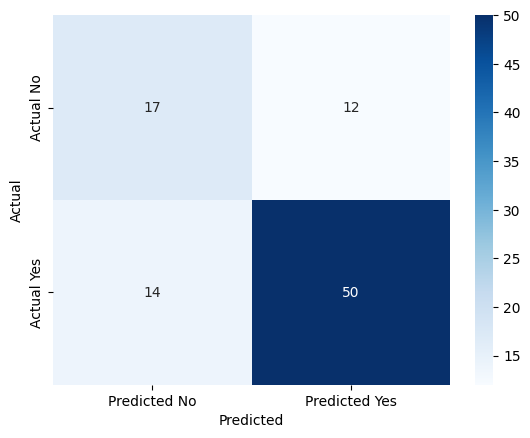

In [345]:
# ANN with scaler
pipe_ann = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPClassifier(random_state=42, max_iter=2000))
])

param_grid_ann = {
    'model__hidden_layer_sizes': [(32,), (64, 32)],
    'model__alpha': [0.001, 0.01],
    'model__activation': ['relu', 'tanh'],
    'model__learning_rate_init': [0.001, 0.01]
}

grid_ann = GridSearchCV(
    pipe_ann,
    param_grid_ann,
    cv=5,
    scoring='precision_macro',
    n_jobs=-1
)

grid_ann.fit(X_train, y_train)

best_model_ann = grid_ann.best_estimator_

calibrated_ann = CalibratedClassifierCV(best_model_ann, method='isotonic', cv=5)
calibrated_ann.fit(X_train, y_train)

y_val_pred_ann = grid_ann.predict(X_val)
y_proba_ann = calibrated_ann.predict_proba(X_val)[:, 1]

y_val_pred_ann = (y_proba_ann >= 0.74).astype(int) # best treshold using treshold tuning

print("LogisticRegression Validation Precision Score:", precision_score(y_val, y_val_pred_ann))
print("Accuracy:", accuracy_score(y_val, y_val_pred_ann))

mat = confusion_matrix(y_val, y_val_pred_ann)
sns.heatmap(
    mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted No', 'Predicted Yes'],
    yticklabels=['Actual No', 'Actual Yes']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')

LogisticRegression Validation Precision Score: 0.7777777777777778
Accuracy: 0.41935483870967744


Text(50.722222222222214, 0.5, 'Actual')

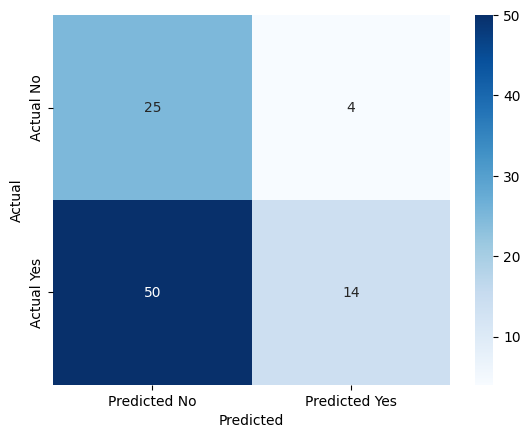

In [367]:
# ANN without scaler
pipe_ann_ns = Pipeline([
    ('model', MLPClassifier(random_state=42, max_iter=2000))
])

param_grid_ann_ns = {
    'model__hidden_layer_sizes': [(32,), (64, 32)],
    'model__alpha': [0.001, 0.01],
    'model__activation': ['relu', 'tanh'],
    'model__learning_rate_init': [0.001, 0.01]
}

grid_ann_ns = GridSearchCV(
    pipe_ann_ns,
    param_grid_ann_ns,
    cv=5,
    scoring='precision_macro',
    n_jobs=-1
)

grid_ann_ns.fit(X_train, y_train)

best_model_ann = grid_ann_ns.best_estimator_

calibrated_ann_ns = CalibratedClassifierCV(best_model_ann, method='isotonic', cv=5)
calibrated_ann_ns.fit(X_train, y_train)

y_val_pred_ann_ns = grid_ann_ns.predict(X_val)
y_proba_ann_ns = calibrated_ann_ns.predict_proba(X_val)[:, 1]
y_val_pred_ann_ns = (y_proba_ann_ns >= 0.74).astype(int) # best treshold using treshold tuning

print("LogisticRegression Validation Precision Score:", precision_score(y_val, y_val_pred_ann_ns))
print("Accuracy:", accuracy_score(y_val, y_val_pred_ann_ns))

mat = confusion_matrix(y_val, y_val_pred_ann_ns)
sns.heatmap(
    mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted No', 'Predicted Yes'],
    yticklabels=['Actual No', 'Actual Yes']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')

As you can see, the impact of not having a scaler on the logistic regression algorithm is not that great and is relatively more noticeable on knn, but the lack of a scaler on ann is officially a disaster.

## Threshold tuning and FP/FN analysis

In this section we vary the decision threshold for each trained model and visualize how False Positives (FP) and False Negatives (FN) change with the threshold. This helps to choose a threshold that controls risk (e.g., reduce FP) while considering the trade-off with FN.

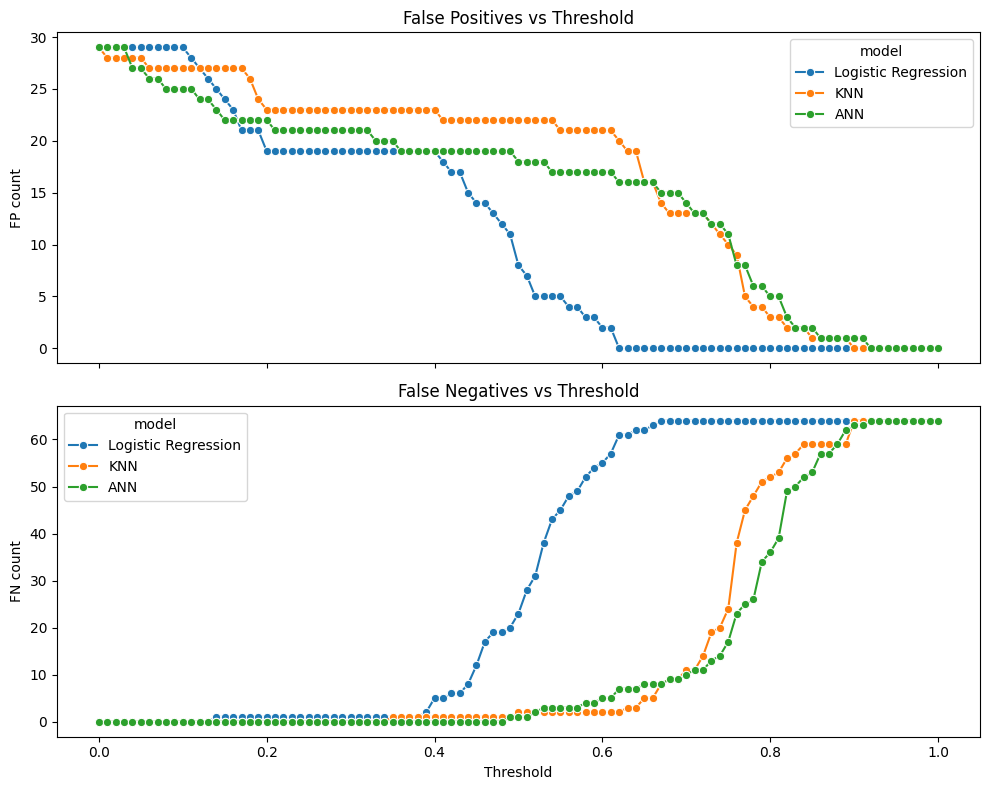

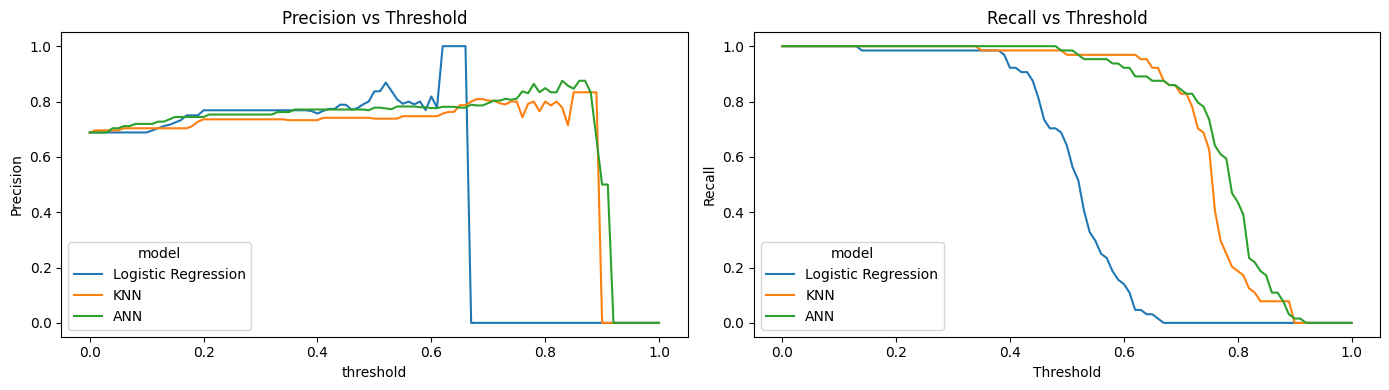

,model,threshold_min_FP_plus_FN,FP_at_this,FN_at_this,threshold_max_precision,precision_at_this
0,Logistic Regression,0.20,19,1,0.62,1.000000
1,KNN,0.65,16,5,0.85,0.833333
2,ANN,0.36,19,0,0.83,0.875000


In [347]:
# thresholds to evaluate
thresholds = np.linspace(0.0, 1.0, 101)

# get predicted probabilities for positive class for each model
# Logistic Regression
y_proba_lr = best_model_lr.predict_proba(X_val)[:, 1]
# KNN (calibrated)
# y_proba_knn already computed in the KNN cell (calibrated_knn predicted & thresholded there)
# ANN (calibrated)
# y_proba_ann already computed in the ANN cell

res_lr = pd.DataFrame(tune_threshold(y_val, y_proba_lr, thresholds))
res_knn = pd.DataFrame(tune_threshold(y_val, y_proba_knn, thresholds))
res_ann = pd.DataFrame(tune_threshold(y_val, y_proba_ann, thresholds))

res_lr['model'] = 'Logistic Regression'
res_knn['model'] = 'KNN'
res_ann['model'] = 'ANN'

res_all = pd.concat([res_lr, res_knn, res_ann], ignore_index=True)

# Plot FP and FN vs Threshold (two subplots)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

sns.lineplot(ax=axes[0], data=res_all, x='threshold', y='FP', hue='model', marker='o')
axes[0].set_title('False Positives vs Threshold')
axes[0].set_ylabel('FP count')

sns.lineplot(ax=axes[1], data=res_all, x='threshold', y='FN', hue='model', marker='o')
axes[1].set_title('False Negatives vs Threshold')
axes[1].set_ylabel('FN count')
axes[1].set_xlabel('Threshold')

plt.tight_layout()
plt.show()

# Also plot precision & recall vs threshold to visualize trade-offs
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.lineplot(ax=axes[0], data=res_all, x='threshold', y='precision', hue='model')
axes[0].set_title('Precision vs Threshold')
axes[0].set_ylabel('Precision')

sns.lineplot(ax=axes[1], data=res_all, x='threshold', y='recall', hue='model')
axes[1].set_title('Recall vs Threshold')
axes[1].set_ylabel('Recall')
axes[1].set_xlabel('Threshold')

plt.tight_layout()
plt.show()

# Summary: suggest candidate thresholds per model
summary = []
for name, df in [('Logistic Regression', res_lr), ('KNN', res_knn), ('ANN', res_ann)]:
    idx_min_sum = (df['FP'] + df['FN']).idxmin()
    t_min_sum = df.loc[idx_min_sum, 'threshold']
    idx_max_prec = df['precision'].idxmax()
    t_max_prec = df.loc[idx_max_prec, 'threshold']
    summary.append({
        'model': name,
        'threshold_min_FP_plus_FN': t_min_sum,
        'FP_at_this': df.loc[idx_min_sum, 'FP'],
        'FN_at_this': df.loc[idx_min_sum, 'FN'],
        'threshold_max_precision': t_max_prec,
        'precision_at_this': df.loc[idx_max_prec, 'precision']
    })

pd.DataFrame(summary)


As you can see, using the diagram drawn, the best numbers were selected as thresholds for the algorithms. In addition, the algorithms were optimized to reduce false positives as much as possible, in addition to the threshold, by using a calibrated classifier and grid search, so that we can have the best results with the best hyperparameters.

**Due to the high cost of false positives, the focus of the model shifted from maximizing accuracy to controlling risk through precision, class weight adjustment, calibrated probability and threshold adjustment.**

# Model Evaluation

In [354]:
y_proba_lr = calibrated_lr.predict_proba(X_test)[:, 1]
y_pred_lr = (y_proba_lr >= 0.74).astype(int)
print("Logistic Regression Test Precision Score:", precision_score(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, zero_division=0))

Logistic Regression Test Precision Score: 0.8717948717948718
Accuracy: 0.7804878048780488
              precision    recall  f1-score   support

       False       0.62      0.74      0.67        38
        True       0.87      0.80      0.83        85

    accuracy                           0.78       123
   macro avg       0.75      0.77      0.75       123
weighted avg       0.79      0.78      0.79       123



In [355]:
y_proba_knn = best_model_knn.predict_proba(X_test)[:, 1]
y_pred_knn = (y_proba_knn >= 0.68).astype(int)
print("KNN Test Precision Score:", precision_score(y_test, y_pred_knn))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, zero_division=0))

KNN Test Precision Score: 0.8470588235294118
Accuracy: 0.7886178861788617
              precision    recall  f1-score   support

       False       0.66      0.66      0.66        38
        True       0.85      0.85      0.85        85

    accuracy                           0.79       123
   macro avg       0.75      0.75      0.75       123
weighted avg       0.79      0.79      0.79       123



In [360]:
y_proba_ann = best_model_ann.predict_proba(X_test)[:, 1]
y_pred_ann = (y_proba_ann >= 0.74).astype(int)
print("ANN Test Precision:", precision_score(y_test, y_pred_ann, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_ann))
print(classification_report(y_test, y_pred_ann, zero_division=0))

ANN Test Precision: 0.8734177215189873
Accuracy: 0.7886178861788617
              precision    recall  f1-score   support

       False       0.64      0.74      0.68        38
        True       0.87      0.81      0.84        85

    accuracy                           0.79       123
   macro avg       0.75      0.77      0.76       123
weighted avg       0.80      0.79      0.79       123



In [ ]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "KNN", "ANN"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_ann)
    ],
    "False Positives": [
        confusion_matrix(y_test, y_pred_lr)[0,1],
        confusion_matrix(y_test, y_pred_knn)[0,1],
        confusion_matrix(y_test, y_pred_ann)[0,1]
    ]
})
results

,Model,Accuracy,False Positives
0,Logistic Regression,0.780488,10
1,KNN,0.788618,13
2,ANN,0.788618,10


# Final Comparison

According to the number of FPs, logistic regression and ann algorithms are at the same level, which have the lowest false positives, and according to their precision, ann algorithm is the best algorithm for this task in terms of metrics.

# Final Result and Insight

In this project, the data was first worked on and its null values ​​were managed and its categorical data was encoded to be understandable for the models.
Then the data was split for training, validation and testing.
Then pipelines were created that contained the model and the scalar and grid search was created on them to find the best hyperparameters.
Then the training and fitting process was performed in a calibrated manner using a calibrated classifier, which had a potential impact on the performance of the models, and the logistic regression algorithm was optimized by class weights, which had a really positive impact on its performance against false positives.
Then the final models were compared with their versions without scalar.
And then the performance of the models was examined relative to each other using the confusion matrix.
Finally, the output of the models was filtered by thresholds to achieve the best output, and the thresholds were selected in a completely optimal way by auxiliary codes that included the threshold tuning function and the graph code.
Finally In the evolution phase, all models were tested with test data, their results were reviewed, and the best model was selected.

We want to have an insight into the ann algorithm and its advantages and disadvantages.
The biggest problem with this algorithm was its execution time during testing and validation, which was high due to the wide range of grid search and max_iter, which made this algorithm strong and slow. However, no specific time problem was observed in the test sample and it was able to outperform the other two algorithms well and with the best metrics.

Personally, I feel that this algorithm and its variety of hyperparameters and various optimizations have been worked on more than the rest of the algorithms, and that is the reason why it is the first.
I will definitely work more on this project and the tennis data project and expand my research with the help of my scikit learn doc and artificial intelligence to turn these models into better models and learn more.
I am currently finishing this project at almost 4 am and I hope that my effort will be accepted by you.
Again, thank you to all of you dear ones at the Bahal Daneshkar collection for this bootcamp, which was the best training course I have ever had in my life.
**Wishing you all the best.**